<a href="https://colab.research.google.com/github/tranduy199984/RB-Revenue-Forecast-Model-SARIMA/blob/main/Sales_Forecast__SARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consider Autoregressive Integrated Moving Average (ARIMA), and Seasonal Autoregressive Integrated Moving-Average SARIMA(p,d,q)(P,D,Q)S​
***
SARIMA models

Non-seasonal orders
p: autoregressive order
d: differencing order
q: moving average order

Seasonal orders
P: seasonal autoregressive order
D: seasonal differencing order
Q: seasonal moving average order
S: Number of time steps per cycle
***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Important: 
1. Always load the data file in .CSV, otherwise it won't work :)
2. Check the accurate file pathway
3. Update the right 'Period' for each market
4. Update the optimal Seasonal Parameters generated from Cell 6

# 1. (Ugly stuff) Loading libraries


In [ ]:
# dataframe opertations - pandas
import pandas as pd
import numpy as np
import os
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Review the accuracy
from sklearn.metrics import mean_absolute_error,mean_squared_error
#stationarity
from statsmodels.tsa.stattools import adfuller
#Auto regressive model
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#Important libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from tqdm import tqdm_notebook

from itertools import product
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import itertools
import warnings
plt.style.use('ggplot')


# 2. Loading data (Check pathways)

In [ ]:
forecast_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Robust Ventures/Raw_data_SARIMA.csv',index_col='Date', parse_dates=True)

(41, 4)
            Revenue  Revenue First Difference  Forecast  \
Date                                                      
2021-11-01     4408                       NaN       NaN   
2021-11-08     4185                       NaN       NaN   
2021-11-15     4410                       NaN       NaN   
2021-11-22     4401                       NaN       NaN   
2021-11-29     4305                       NaN       NaN   

            Seasonal First Difference  
Date                                   
2021-11-01                        NaN  
2021-11-08                        NaN  
2021-11-15                        NaN  
2021-11-22                        NaN  
2021-11-29                        NaN  


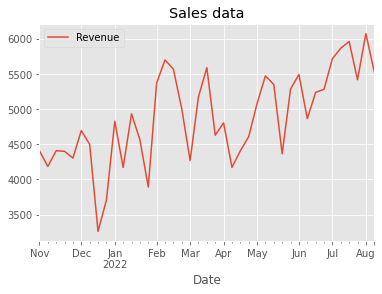

In [ ]:
Raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Robust Ventures/Raw_data_SARIMA.csv',index_col='Date', parse_dates=True)


# finding shape of the dataframe
print(Raw_data.shape)
# having a look at the data
print(Raw_data.head())
# plotting the original data
Raw_data[['Revenue']].plot(title='Sales data')

In [ ]:
#Checking if there is any missing values

Raw_data.isnull().sum()

Revenue                       0
Revenue First Difference     41
Forecast                     41
Seasonal First Difference    41
dtype: int64

# 3. Primary Augmented Dickey-Fuller test (Testing stationarity)

In [ ]:
# Testing stationarity
test_result = adfuller(Raw_data['Revenue'])

In [ ]:
#H0: Not stationary
#H1: Stationary

def adfuller_test(Revenue):
  result = adfuller(Revenue)
  labels = ['ADG Test Stats', 'p-value', '# Lags used', 'Number of Observations used']
  for value, label in zip(result,labels):
    print(label+' : ' + str(value))
  if result[1] <= 0.05:
    print('Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary')
  else:
    print('Week evidence against null hypothesis, time series has a unit root, and is non-stationary')


In [ ]:
adfuller_test(Raw_data['Revenue'])

ADG Test Stats : -3.188769475438362
p-value : 0.02064401888331427
# Lags used : 0
Number of Observations used : 40
Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary


# 4. (Ugly stuff) Differencing Test

In [ ]:
Raw_data['Revenue First Difference'] = Raw_data['Revenue'] - Raw_data['Revenue'].shift(1)
Raw_data.dropna(subset = ["Revenue First Difference"], inplace=True)
Raw_data.head()

,Revenue,Revenue First Difference,Forecast,Seasonal First Difference
Date,,,,
2021-11-08,4185,-223.0,NaN,NaN
2021-11-15,4410,225.0,NaN,NaN
2021-11-22,4401,-9.0,NaN,NaN
2021-11-29,4305,-96.0,NaN,NaN
2021-12-06,4697,392.0,NaN,NaN


In [ ]:
Raw_data['Revenue'].shift(1)

Date
2021-11-08       NaN
2021-11-15    4185.0
2021-11-22    4410.0
2021-11-29    4401.0
2021-12-06    4305.0
2021-12-13    4697.0
2021-12-20    4499.0
2021-12-27    3262.0
2022-01-03    3705.0
2022-01-10    4829.0
2022-01-17    4171.0
2022-01-24    4934.0
2022-01-31    4566.0
2022-02-07    3893.0
2022-02-14    5372.0
2022-02-21    5702.0
2022-02-28    5572.0
2022-03-07    5007.0
2022-03-14    4270.0
2022-03-21    5178.0
2022-03-28    5592.0
2022-04-04    4630.0
2022-04-11    4806.0
2022-04-18    4172.0
2022-04-25    4408.0
2022-05-02    4609.0
2022-05-09    5081.0
2022-05-16    5475.0
2022-05-23    5351.0
2022-05-30    4365.0
2022-06-06    5287.0
2022-06-13    5495.0
2022-06-20    4866.0
2022-06-27    5240.0
2022-07-04    5284.0
2022-07-11    5719.0
2022-07-18    5869.0
2022-07-25    5964.0
2022-08-01    5419.0
2022-08-08    6076.0
Name: Revenue, dtype: float64

In [ ]:
# Again test dickey fuller test
adfuller_test(Raw_data['Revenue First Difference'].dropna())

ADG Test Stats : -5.9800741233465615
p-value : 1.8475072679460216e-07
# Lags used : 3
Number of Observations used : 36
Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary


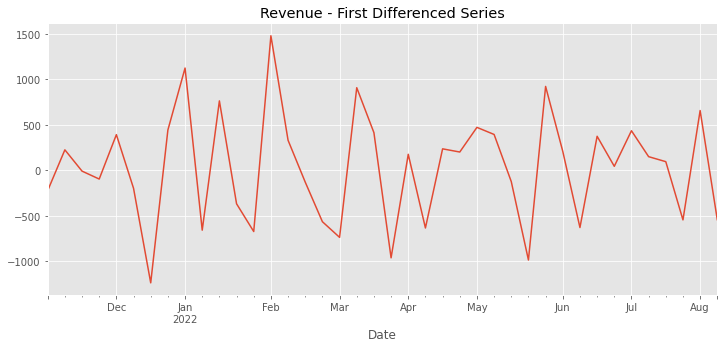

In [ ]:
plt.figure(figsize=[12, 5]); # Set dimensions for figure
Raw_data['Revenue First Difference'].plot()
plt.title('Revenue - First Differenced Series')
plt.grid(True)


ACF
PACF


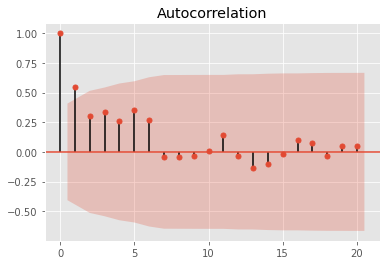

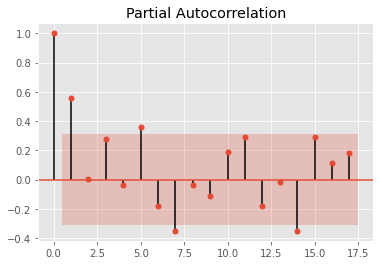

In [ ]:
# ACF
print('ACF')
plot_acf(Raw_data['Revenue'], lags=20,alpha=0.01);

#PACF
print('PACF')
plot_pacf(Raw_data['Revenue']);

# 5. (***) Updating accurate Difference index

In [ ]:
Raw_data['Seasonal First Difference'] = Raw_data['Revenue'] - Raw_data['Revenue'].shift(1)

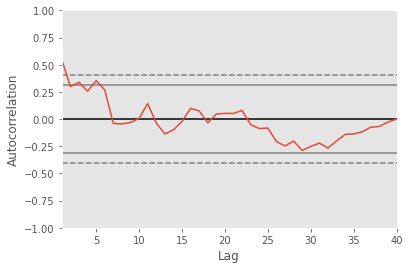

In [ ]:
autocorrelation_plot(Raw_data['Revenue'])
plt.show()

# 6. Finding the best parameter of Seasonality (Testing Akaike information criterion)

In [ ]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],4) for x in list(itertools.product(p,d,q))]
parameters = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Raw_data['Revenue'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        aic = results.aic
        parameters.append([param,param_seasonal,aic])

result_table = pd.DataFrame(parameters)
result_table.columns = ['parameters',     'parameters_seasonal','aic']
result_table = result_table.sort_values(by='aic',ascending = True).reset_index(drop = True)
minimum = result_table['aic'].min()
a = result_table.loc[result_table['aic'] == minimum]
print(' The best combination that gives the lowest AIC is:')
print(a)

ARIMA(0, 0, 0)x(0, 0, 0, 4)52 - AIC:776.4878248637898
ARIMA(0, 0, 0)x(0, 0, 1, 4)52 - AIC:678.9983554563007
ARIMA(0, 0, 0)x(0, 1, 0, 4)52 - AIC:566.0205817379119
ARIMA(0, 0, 0)x(0, 1, 1, 4)52 - AIC:499.6667092804581
ARIMA(0, 0, 0)x(1, 0, 0, 4)52 - AIC:582.873442251647
ARIMA(0, 0, 0)x(1, 0, 1, 4)52 - AIC:556.5270449558567
ARIMA(0, 0, 0)x(1, 1, 0, 4)52 - AIC:515.366757043794
ARIMA(0, 0, 0)x(1, 1, 1, 4)52 - AIC:498.08491773911044
ARIMA(0, 0, 1)x(0, 0, 0, 4)52 - AIC:732.3228884286086
ARIMA(0, 0, 1)x(0, 0, 1, 4)52 - AIC:608.9438797467049
ARIMA(0, 0, 1)x(0, 1, 0, 4)52 - AIC:551.267063803052
ARIMA(0, 0, 1)x(0, 1, 1, 4)52 - AIC:481.8706087530883
ARIMA(0, 0, 1)x(1, 0, 0, 4)52 - AIC:583.3101778570369
ARIMA(0, 0, 1)x(1, 0, 1, 4)52 - AIC:541.3192790632186
ARIMA(0, 0, 1)x(1, 1, 0, 4)52 - AIC:508.4507728986229
ARIMA(0, 0, 1)x(1, 1, 1, 4)52 - AIC:477.2377666768744
ARIMA(0, 1, 0)x(0, 0, 0, 4)52 - AIC:598.1186554417516
ARIMA(0, 1, 0)x(0, 0, 1, 4)52 - AIC:539.048656022004
ARIMA(0, 1, 0)x(0, 1, 0, 4)52 -

# 7. Auto Regressive Model

In [ ]:
# Updated the optimal Parameters generated from Cell 6 (above)

# SARIMA model running

best_model = SARIMAX(Raw_data['Revenue'], order=(0, 1, 1)  , seasonal_order=(0, 1, 1, 4)).fit(dis=-1)

print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                   40
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -276.974
Date:                           Thu, 25 Aug 2022   AIC                            559.947
Time:                                   17:30:57   BIC                            564.613
Sample:                               11-08-2021   HQIC                           561.558
                                    - 08-08-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7971      0.165     -4.844      0.000      -1.120      -0.475
ma.S.L4       -0.9977      0.307     -3.247

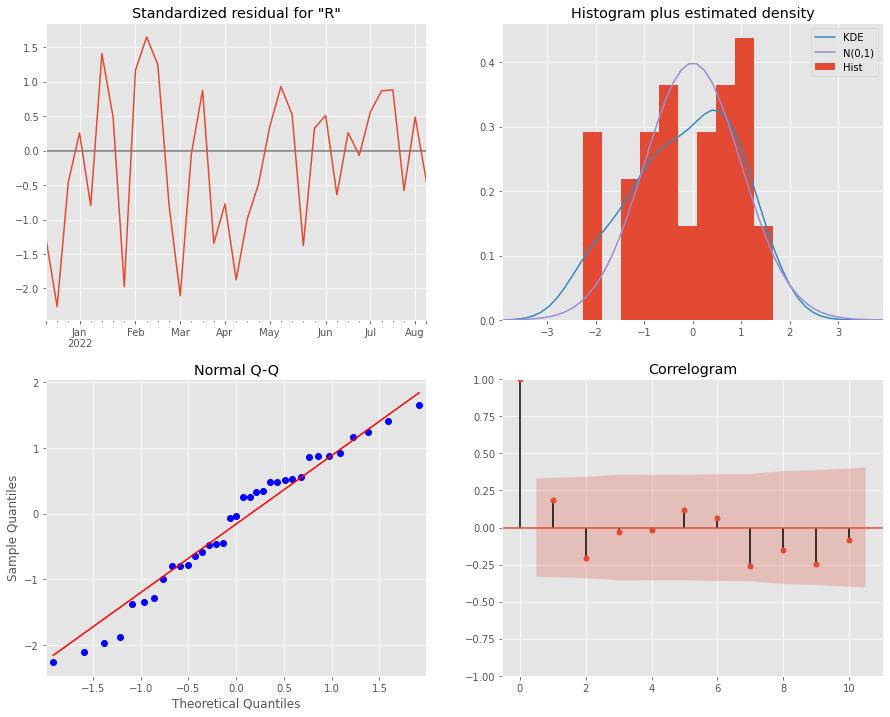

In [ ]:
#Diagnosing the model residuals
best_model.plot_diagnostics(figsize=(15,12));

#The correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise. Therefore, these residuals are uncorrelated and the mean is close to zero.

# 8. Forecast Results

AttributeError: ignored

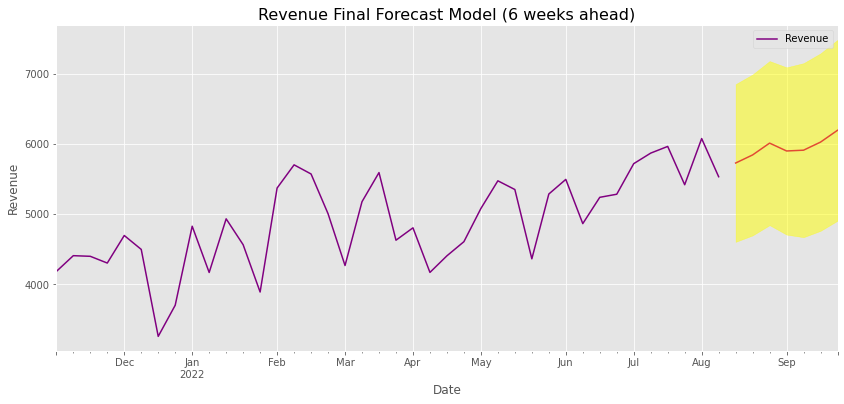

In [ ]:
#Forecasting 6 weeks ahead
forecast_values = best_model.get_forecast(steps = 7)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = Raw_data['Revenue'].plot(figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Revenue Final Forecast Model (6 weeks ahead)', size = 16)
plt.xlabel('Date')
plt.ylabel('Revenue',loc="best",size=12)
plt.legend('y', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)

#annotation
ax.text(540, 400, '6 weeks Forecast', fontsize=12,  color='red')
plt.show()

# 9. (Ugly stuff) Forecast Range (Upper and Lower)

In [ ]:
forecast_values.conf_int()

,lower Revenue,upper Revenue
2022-08-15,4606.371383,6849.482009
2022-08-22,4698.576681,6987.521580
2022-08-29,4844.232135,7178.027553
2022-09-05,4709.889346,7088.657632
2022-09-12,4673.050850,7148.043002
2022-09-19,4763.624399,7287.714321
2022-09-26,4907.648952,7479.851195


# 10. FINAL RESULT & EVALUATION METRICS

In [ ]:
## Mean values of final 6 weeks forecast 
forecast_values.predicted_mean

2022-08-15    5727.926696
2022-08-22    5843.049130
2022-08-29    6011.129844
2022-09-05    5899.273489
2022-09-12    5910.546926
2022-09-19    6025.669360
2022-09-26    6193.750074
Freq: W-MON, Name: predicted_mean, dtype: float64

In [ ]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 

# the test model use 85% of the total Dataframe to test the overal forecast (extraction methods)  

train = Raw_data[:int(0.85*(len(Raw_data)))]
test = Raw_data[int(0.85*(len(Raw_data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Revenue'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Revenue'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Revenue'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['Revenue'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Revenue'])
                                                               /np.abs(test['Revenue']))*100 
evaluation_results


,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,-1.686013,366.650248,144497.355271,380.128077,6.343995


In [ ]:
print('The mean absolute percentage error (MAPE) is (%)')
print(evaluation_results['mean_absolute_percentage_error'])

The mean absolute percentage error (MAPE) is (%)
0    6.343995
Name: mean_absolute_percentage_error, dtype: float64
